# Can we predict big budget movie flops?

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import json
from datetime import datetime
from wordcloud import WordCloud
from scipy.stats import ttest_ind, shapiro, mannwhitneyu

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, accuracy_score, roc_auc_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.utils import resample
from sklearn.preprocessing import normalize

In [2]:
credits_df = pd.read_csv(r"TMDb dataset\archive\tmdb_5000_credits.csv")
movies_df = pd.read_csv(r"TMDb dataset\archive\tmdb_5000_movies.csv")

print(credits_df.shape, movies_df.shape)

(4803, 4) (4803, 20)


# Questions

1. Which genre of movies is the most profitable?
2. Is there a discernable difference between keywords associated with flops vs successes?
3. Are box office successes rated higher?
4. Is there a temporal component to flops vs successes? 
5. Can we predict box office flops?

In [3]:
credits_df.head()

,movie_id,title,cast,crew
0,19995,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,285,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,206647,Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,49026,The Dark Knight Rises,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,49529,John Carter,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."


In [4]:
a = json.loads(credits_df.iloc[2,3])
a[0]["name"]

'Thomas Newman'

In [5]:
movies_df.loc[0, "production_companies"]

'[{"name": "Ingenious Film Partners", "id": 289}, {"name": "Twentieth Century Fox Film Corporation", "id": 306}, {"name": "Dune Entertainment", "id": 444}, {"name": "Lightstorm Entertainment", "id": 574}]'

In [6]:
movies_df.head()

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124


# EDA + Functions

In [7]:
def gen_metadata_df(metadata_df, col):
    """
    Pre-processing. Generates DataFrame of all metadata with movie ids. 
    
    Args:
        metadata_df = DataFrame, original dataframe
        col = str, column to be converted to a separate DataFrame
    Returns:
        Structured DataFrame from metadata column by movie_id
    """
    
    dfs = []

    for ix in range(metadata_df.shape[0]):
        temp = metadata_df[col].iloc[ix]
        movie_id = metadata_df.movie_id.iloc[ix]
        
        # Required as some IDs have malfunctioned and should not be included.
        try:
            pd.read_json(temp)
        except OverflowError as e:
            print(e)
            continue
        else:
            temp_df = pd.read_json(temp)
            temp_df["movie_id"] = movie_id
            dfs.append(temp_df)

    df = pd.concat(dfs, sort=True) # Silence warning
    df.reset_index(inplace=True)
    df.sort_values(by="movie_id", ascending=True)
    
    return df

In [8]:
def remove_outliers(x, s=3):
    """
    Removes outliers above a certain standard deviation using scipy.stats.zscore.
    
    Args:
        x = list or pd.Series, 1d data
        s = int or float, standard deviation threshold, default 3
        
    Returns:
        list of values with outliers removed
    """
    
    from scipy.stats import zscore
    
    if isinstance(x, pd.Series):
        x = x.values
    
    return [i for i, z in zip(x, zscore(x)) if z < s]        

In [9]:
def get_credits_data(row, df, col, value):
    """
    Return data from crew_df or cast_df for specific column value across all movies.
    
    Args:
        row: Series, obj in apply function
        df: DataFrame, cast_df or crew_df
        col: str, column name to be queried
        value: str or numeric, value to query
        
    Returns:
        str for name
    """    
    return_df = df[(df.movie_id == row.movie_id) & (df[col] == value)] 

    if row.movie_id in df.movie_id.unique() and return_df.empty == False:
        return return_df.name.values[0]
    else:
        return np.nan 

In [10]:
def gen_wordcloud(keywords_df):
    # https://www.datacamp.com/community/tutorials/wordcloud-python
    joined_keywords = (" ").join(keywords_df.name.tolist())
    keyword_wordcloud = WordCloud().generate(joined_keywords)

    plt.imshow(keyword_wordcloud, interpolation='bilinear')
    plt.axis("off")
    return plt.show()

In [11]:
cast_df = gen_metadata_df(credits_df, col="cast")
crew_df = gen_metadata_df(credits_df, col="crew")
print(cast_df.shape, crew_df.shape)
cast_df.head()

int too big to convert
int too big to convert
int too big to convert
int too big to convert
(106257, 9) (129460, 8)


,index,cast_id,character,credit_id,gender,id,movie_id,name,order
0,0.0,242.0,Jake Sully,5602a8a7c3a3685532001c9a,2.0,65731.0,19995,Sam Worthington,0.0
1,1.0,3.0,Neytiri,52fe48009251416c750ac9cb,1.0,8691.0,19995,Zoe Saldana,1.0
2,2.0,25.0,Dr. Grace Augustine,52fe48009251416c750aca39,1.0,10205.0,19995,Sigourney Weaver,2.0
3,3.0,4.0,Col. Quaritch,52fe48009251416c750ac9cf,2.0,32747.0,19995,Stephen Lang,3.0
4,4.0,5.0,Trudy Chacon,52fe48009251416c750ac9d3,1.0,17647.0,19995,Michelle Rodriguez,4.0


In [12]:
cast_df[cast_df.order == 0.0]

,index,cast_id,character,credit_id,gender,id,movie_id,name,order
0,0.0,242.0,Jake Sully,5602a8a7c3a3685532001c9a,2.0,65731.0,19995,Sam Worthington,0.0
83,0.0,4.0,Captain Jack Sparrow,52fe4232c3a36847f800b50d,2.0,85.0,285,Johnny Depp,0.0
117,0.0,1.0,James Bond,52fe4d22c3a368484e1d8d6b,2.0,8784.0,206647,Daniel Craig,0.0
200,0.0,2.0,Bruce Wayne / Batman,52fe4781c3a36847f8139869,2.0,3894.0,49026,Christian Bale,0.0
358,0.0,5.0,John Carter,52fe479ac3a36847f813ea75,2.0,60900.0,49529,Taylor Kitsch,0.0
...,...,...,...,...,...,...,...,...,...
106225,0.0,1.0,El Mariachi,52fe44eec3a36847f80b27f9,2.0,20498.0,9367,Carlos Gallardo,0.0
106232,0.0,1.0,Buzzy,52fe487dc3a368484e0fb001,2.0,12833.0,72766,Edward Burns,0.0
106237,0.0,8.0,Oliver O’Toole,52fe4df3c3a36847f8275ed3,2.0,11867.0,231617,Eric Mabius,0.0
106244,0.0,3.0,Sam,52fe4ad9c3a368484e16a375,2.0,82093.0,126186,Daniel Henney,0.0


In [13]:
crew_df.head()

,index,credit_id,department,gender,id,job,movie_id,name
0,0.0,52fe48009251416c750aca23,Editing,0.0,1721.0,Editor,19995,Stephen E. Rivkin
1,1.0,539c47ecc3a36810e3001f87,Art,2.0,496.0,Production Design,19995,Rick Carter
2,2.0,54491c89c3a3680fb4001cf7,Sound,0.0,900.0,Sound Designer,19995,Christopher Boyes
3,3.0,54491cb70e0a267480001bd0,Sound,0.0,900.0,Supervising Sound Editor,19995,Christopher Boyes
4,4.0,539c4a4cc3a36810c9002101,Production,1.0,1262.0,Casting,19995,Mali Finn


In [14]:
cast_df = cast_df[cast_df.movie_id.isin(crew_df.movie_id.unique())]
movies_df = movies_df[movies_df.id.isin(crew_df.movie_id.unique())]
movies_df.rename({"id":"movie_id"}, inplace=True, axis=1)

In [15]:
movies_df["director"] = movies_df.apply(lambda row: get_credits_data(row, crew_df, "job", "Director"), axis=1)

In [16]:
movies_df["lead_actor"] = movies_df.apply(lambda row: get_credits_data(row, cast_df, "order", 0.0), axis=1)

In [17]:
genres_df = gen_metadata_df(movies_df, col='genres')
genres_df.shape

(12120, 4)

In [18]:
genres_df["budget"] = genres_df.apply(lambda row: movies_df[movies_df.movie_id == row.movie_id].budget.values[0], axis=1)

In [19]:
genres_df.head()

,index,id,movie_id,name,budget
0,0.0,28.0,19995,Action,237000000
1,1.0,12.0,19995,Adventure,237000000
2,2.0,14.0,19995,Fantasy,237000000
3,3.0,878.0,19995,Science Fiction,237000000
4,0.0,12.0,285,Adventure,300000000


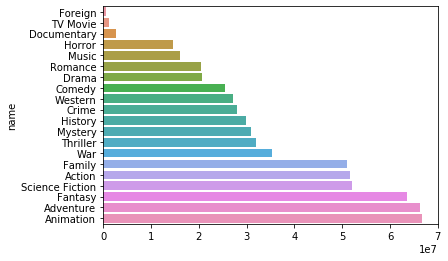

In [20]:
temp = genres_df.groupby(["name"]).budget.mean().sort_values(ascending=True)

sns.barplot(temp.values, temp.index, orient='h', order=temp.index.tolist().reverse())

In [21]:
movies_df["profit"] = movies_df.revenue - movies_df.budget

In [22]:
movies_df.release_date = pd.to_datetime(movies_df.release_date)

In [23]:
print(movies_df[movies_df.budget != 0].shape, movies_df[movies_df.revenue != 0].shape, movies_df[(movies_df.budget != 0) & (movies_df.revenue != 0)].shape)

(3757, 23) (3370, 23) (3224, 23)


In [24]:
new_movies_df = movies_df[(movies_df.budget != 0) & (movies_df.revenue != 0)]

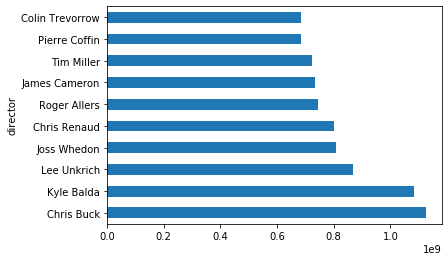

In [25]:
new_movies_df.groupby(["director"]).profit.mean().sort_values(ascending=False)[:10].plot(kind='barh')

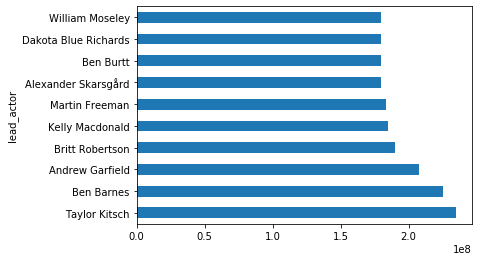

In [26]:
new_movies_df.groupby(["lead_actor"]).budget.mean().sort_values(ascending=False)[:10].plot(kind='barh')

In [27]:
genres_df["profit"] = genres_df.apply(lambda row: movies_df[movies_df.movie_id == row.movie_id].profit.values[0], axis=1)

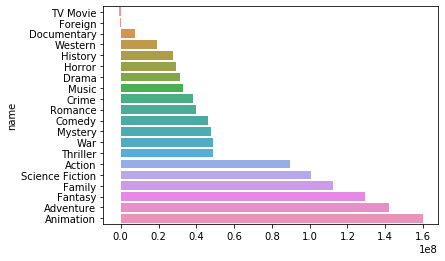

In [28]:
temp = genres_df.groupby(["name"]).profit.mean().sort_values(ascending=True)

sns.barplot(temp.values, temp.index, orient='h')

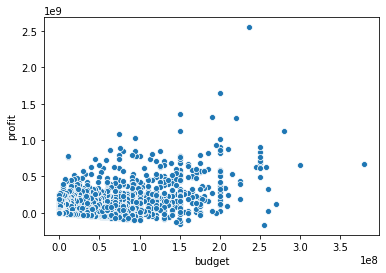

In [29]:
sns.scatterplot(x="budget", y="profit", data=movies_df)

In [30]:
genres_merged = new_movies_df.merge(genres_df, on='movie_id', how='inner')

In [31]:
genres_merged.head()

,budget_x,genres,homepage,movie_id,keywords,original_language,original_title,overview,popularity,production_companies,...,vote_average,vote_count,director,lead_actor,profit_x,index,id,name,budget_y,profit_y
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...",...,7.2,11800,James Cameron,Sam Worthington,2550965087,0.0,28.0,Action,237000000,2550965087
1,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...",...,7.2,11800,James Cameron,Sam Worthington,2550965087,1.0,12.0,Adventure,237000000,2550965087
2,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...",...,7.2,11800,James Cameron,Sam Worthington,2550965087,2.0,14.0,Fantasy,237000000,2550965087
3,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...",...,7.2,11800,James Cameron,Sam Worthington,2550965087,3.0,878.0,Science Fiction,237000000,2550965087
4,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...",...,6.9,4500,Gore Verbinski,Johnny Depp,661000000,0.0,12.0,Adventure,300000000,661000000


# Count of movies by genre segmentation

As we see from the profit distributions of each genre, an average would be a highly skewed measure of central tendency due to the non-normal nature of each distribution. In this case median may work better to understand true differences.

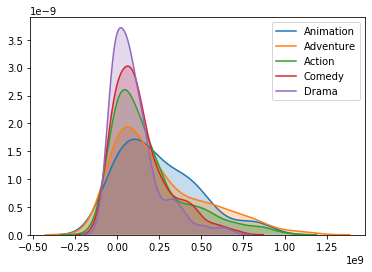

In [32]:
sns.kdeplot(remove_outliers(genres_merged[(genres_merged.budget_x > 50000000) & (genres_merged.name == 'Animation')].profit_x), shade=True, label="Animation")
sns.kdeplot(remove_outliers(genres_merged[(genres_merged.budget_x > 50000000) & (genres_merged.name == 'Adventure')].profit_x), shade=True, label="Adventure")
sns.kdeplot(remove_outliers(genres_merged[(genres_merged.budget_x > 50000000) & (genres_merged.name == 'Action')].profit_x), shade=True, label="Action")
sns.kdeplot(remove_outliers(genres_merged[(genres_merged.budget_x > 50000000) & (genres_merged.name == 'Comedy')].profit_x), shade=True, label="Comedy")
sns.kdeplot(remove_outliers(genres_merged[(genres_merged.budget_x > 50000000) & (genres_merged.name == 'Drama')].profit_x), shade=True, label="Drama")

From the below graph, a large discrepency can be noticed between the fact that animation films have the lowest market share vs the fact that animation films are on average the most profitable films.

Text(0.5, 0, 'Genre')

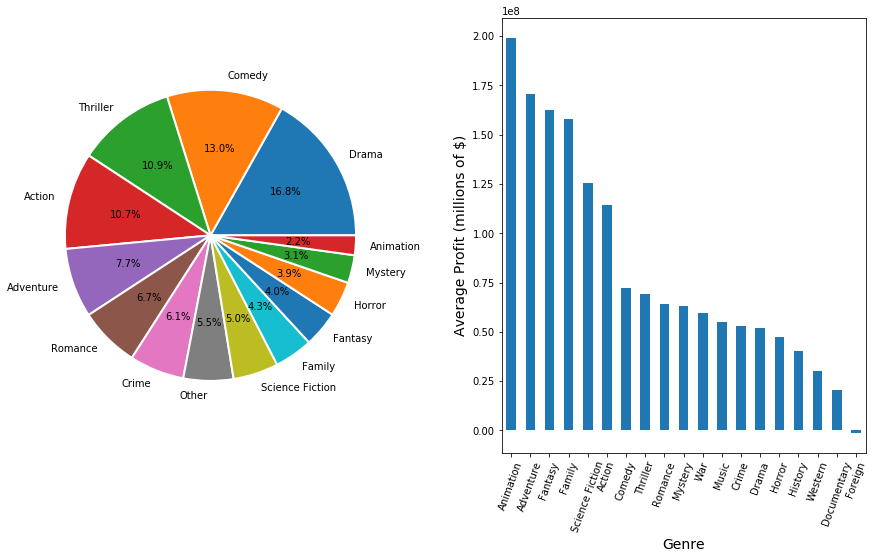

In [33]:
bar_series = genres_merged.name.value_counts() / genres_merged.shape[0]
bar_series.index = [bar_series.index[i] if bar_series[i] > 0.02 else 'Other' for i in range(len(bar_series))]
bar_series = bar_series.groupby(by = bar_series.index).sum().sort_values(ascending=False)

plt.figure(figsize=(15, 8))
plt.subplots_adjust(wspace=0.3)
plt.subplot(121)
plt.pie(bar_series, labels=bar_series.index, autopct='%.1f%%', 
        wedgeprops={'linewidth': 2.0, 'edgecolor': 'white'}) #bar_series.sort_values(ascending=False).plot(kind='pie')
plt.subplot(122)
genres_merged.groupby("name").profit_x.mean().sort_values(ascending=False).plot(kind='bar', rot=70)
plt.ylabel("Average Profit (millions of $)", fontsize=14)
plt.xlabel("Genre", fontsize=14)

## Segmentation for big budget movies

When segmenting for big budget movies (in this case >50 mil), we can see the same trend emerge, leading us to believe that most animation films have a much higher budget.

Text(0.5, 0, 'Genre')

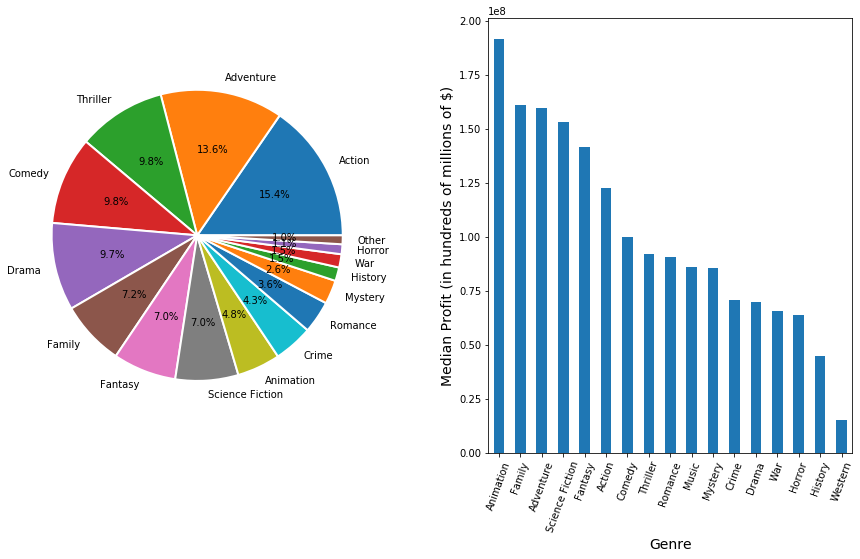

In [34]:
bar_series = genres_merged[genres_merged.budget_x > 50000000].name.value_counts() / genres_merged[genres_merged.budget_x > 100000000].shape[0]
bar_series.index = [bar_series.index[i] if bar_series[i] > 0.02 else 'Other' for i in range(len(bar_series))]
bar_series = bar_series.groupby(by = bar_series.index).sum().sort_values(ascending=False)

plt.figure(figsize=(15, 8))
plt.subplots_adjust(wspace=0.3)
plt.subplot(121)
plt.pie(bar_series, labels=bar_series.index, autopct='%.1f%%', 
        wedgeprops={'linewidth': 2.0, 'edgecolor': 'white'}) #bar_series.sort_values(ascending=False).plot(kind='pie')
plt.subplot(122)
genres_merged[genres_merged.budget_x > 50000000].groupby("name").profit_x.median().sort_values(ascending=False).plot(kind='bar', rot=70)
plt.ylabel("Median Profit (in hundreds of millions of $)", fontsize=14)
plt.xlabel("Genre", fontsize=14)

In [35]:
genres_merged["BoxOfficeSuccess"] = genres_merged.apply(lambda row: (1 if row.profit_x >= 0 else 0), axis=1)

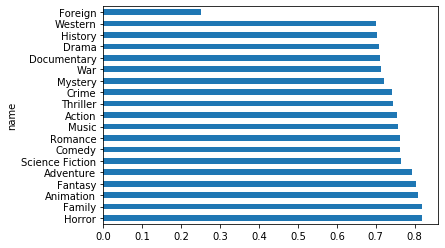

In [36]:
pd.Series(genres_merged.groupby("name")["BoxOfficeSuccess"].sum() / genres_merged.groupby("name")["BoxOfficeSuccess"].count()).sort_values(ascending=False).plot(kind='barh')

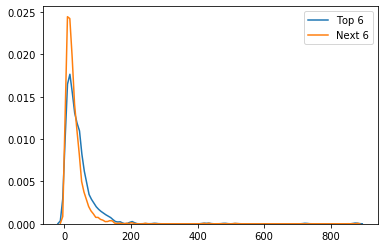

In [37]:
sns.kdeplot(genres_merged[genres_merged.name.isin(genres_merged.groupby("name").profit_x.mean().sort_values(ascending=False).index[:5])].popularity, label='Top 6')
sns.kdeplot(genres_merged[genres_merged.name.isin(genres_merged.groupby("name").profit_x.mean().sort_values(ascending=False).index[5:11])].popularity, label='Next 6')

In [38]:
production_df = gen_metadata_df(movies_df, "production_companies")

In [39]:
temp = genres_merged[["movie_id", "name"]]
temp = pd.get_dummies(temp)
temp = temp.groupby("movie_id", as_index=False).sum()
movies_df.select_dtypes(include=["int64", "float64"]).merge(temp, on="movie_id")

,budget,movie_id,popularity,revenue,runtime,vote_average,vote_count,profit,name_Action,name_Adventure,...,name_Foreign,name_History,name_Horror,name_Music,name_Mystery,name_Romance,name_Science Fiction,name_Thriller,name_War,name_Western
0,237000000,19995,150.437577,2787965087,162.0,7.2,11800,2550965087,1,1,...,0,0,0,0,0,0,1,0,0,0
1,300000000,285,139.082615,961000000,169.0,6.9,4500,661000000,1,1,...,0,0,0,0,0,0,0,0,0,0
2,245000000,206647,107.376788,880674609,148.0,6.3,4466,635674609,1,1,...,0,0,0,0,0,0,0,0,0,0
3,250000000,49026,112.312950,1084939099,165.0,7.6,9106,834939099,1,0,...,0,0,0,0,0,0,0,1,0,0
4,260000000,49529,43.926995,284139100,132.0,6.1,2124,24139100,1,1,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3219,27000,2292,19.748658,3151130,92.0,7.4,755,3124130,0,0,...,0,0,0,0,0,0,0,0,0,0
3220,12000,692,4.553644,6000000,93.0,6.2,110,5988000,0,0,...,0,0,1,0,0,0,0,0,0,0
3221,20000,36095,0.212443,99000,111.0,7.4,63,79000,0,0,...,0,0,1,0,1,0,0,1,0,0
3222,7000,14337,23.307949,424760,77.0,6.9,658,417760,0,0,...,0,0,0,0,0,0,1,1,0,0


# Keywords wordcloud

In [40]:
keywords_df = gen_metadata_df(movies_df, "keywords")

In [41]:
keywords_df.head()

,index,id,movie_id,name
0,0.0,1463.0,19995,culture clash
1,1.0,2964.0,19995,future
2,2.0,3386.0,19995,space war
3,3.0,3388.0,19995,space colony
4,4.0,3679.0,19995,society


In [42]:
keywords_df[keywords_df.name == 'duringcreditsstinger']

,index,id,movie_id,name
109,12.0,179431.0,38757,duringcreditsstinger
118,6.0,179431.0,99861,duringcreditsstinger
208,8.0,179431.0,24428,duringcreditsstinger
254,11.0,179431.0,1930,duringcreditsstinger
316,8.0,179431.0,271110,duringcreditsstinger
...,...,...,...,...
32767,6.0,179431.0,39013,duringcreditsstinger
33231,2.0,179431.0,58492,duringcreditsstinger
33801,0.0,179431.0,38570,duringcreditsstinger
33907,10.0,179431.0,39939,duringcreditsstinger


In [43]:
top6_movie_ids = genres_df[genres_df.name.isin(genres_merged.groupby("name").profit_x.mean().sort_values(ascending=False).index[:5])].movie_id.unique()
next6_movie_ids = genres_df[genres_df.name.isin(genres_merged.groupby("name").profit_x.mean().sort_values(ascending=False).index[5:11])].movie_id.unique()

In [44]:
top100_popular = movies_df.sort_values("popularity", ascending=False).movie_id.values[:100]
next100_popular = movies_df.sort_values("popularity", ascending=False).movie_id.values[100:200]
bottom100_popular = movies_df.sort_values("popularity", ascending=False).movie_id.values[-100:]

In [45]:
boxoffice_successes = movies_df[movies_df.profit > 0].movie_id.unique()
boxoffice_flops = movies_df[movies_df.profit <= 0].movie_id.unique()

In [46]:
bigbudget_boxoffice_successes = movies_df[(movies_df.profit > 0) & (movies_df.budget > 50000000)].movie_id.unique()
bigbudget_boxoffice_flops = movies_df[(movies_df.profit <= 0) & (movies_df.budget > 50000000)].movie_id.unique()

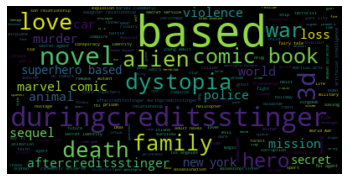

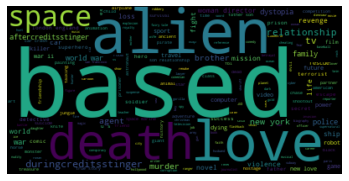

In [47]:
gen_wordcloud(keywords_df[keywords_df.movie_id.isin(bigbudget_boxoffice_successes)])
gen_wordcloud(keywords_df[keywords_df.movie_id.isin(bigbudget_boxoffice_flops)])

In [48]:
movies_df[movies_df.movie_id.isin(bigbudget_boxoffice_successes)].title.values

array(['Avatar', "Pirates of the Caribbean: At World's End", 'Spectre',
       'The Dark Knight Rises', 'John Carter', 'Spider-Man 3', 'Tangled',
       'Avengers: Age of Ultron',
       'Harry Potter and the Half-Blood Prince',
       'Batman v Superman: Dawn of Justice', 'Superman Returns',
       'Quantum of Solace', "Pirates of the Caribbean: Dead Man's Chest",
       'Man of Steel', 'The Chronicles of Narnia: Prince Caspian',
       'The Avengers', 'Pirates of the Caribbean: On Stranger Tides',
       'Men in Black 3', 'The Hobbit: The Battle of the Five Armies',
       'The Amazing Spider-Man', 'Robin Hood',
       'The Hobbit: The Desolation of Smaug', 'The Golden Compass',
       'King Kong', 'Titanic', 'Captain America: Civil War', 'Battleship',
       'Jurassic World', 'Skyfall', 'Spider-Man 2', 'Iron Man 3',
       'Alice in Wonderland', 'X-Men: The Last Stand',
       'Monsters University', 'Transformers: Revenge of the Fallen',
       'Transformers: Age of Extinction', 'Oz

In [49]:
movies_df[movies_df.budget > 50000000].shape

(889, 23)

In [50]:
keywords_df[keywords_df.name.str.contains("based")].name.unique()

array(['based on novel', 'based on fairy tale', 'based on comic book',
       'based on young adult novel', 'based on board game',
       'based on video game', 'based on cartoon', 'based on tv series',
       'based on true story', 'based on toy', 'based on greek myth',
       "based on children's book", 'space based weapon',
       'based on true events', 'based on graphic novel',
       'based on article', 'based on comic strip',
       'based on stage musical', 'based on film', 'based on folk tale',
       'based on short story', 'based on radio show', 'based on play',
       'based on adaptation', 'based on supposedly true story',
       'based on the bible', 'based on memoir', 'based on short film',
       'based on real events'], dtype=object)

In [51]:
genres_merged.groupby("name").profit_x.mean().sort_values(ascending=False).index[5:11]

Index(['Action', 'Comedy', 'Thriller', 'Romance', 'Mystery', 'War'], dtype='object', name='name')

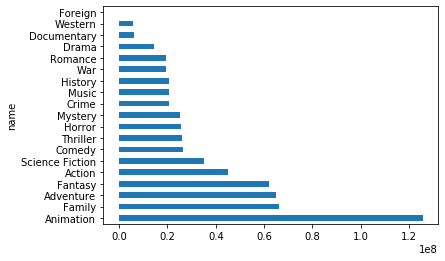

In [52]:
temp2 = genres_merged.groupby("name").profit_x.median() #/ genres_merged.name.value_counts()
temp2.sort_values(ascending=False, inplace=True)

temp2.plot(kind='barh')

# Sucesses vs Flops analysis

Box office success mean=6.38, std=0.74, num samples=699, shapiro-wilk=(0.9938263893127441, 0.005836287513375282)
Box office flop mean=5.68, std=0.87, num samples=190, shapiro-wilk=(0.9769508242607117, 0.003147765528410673)


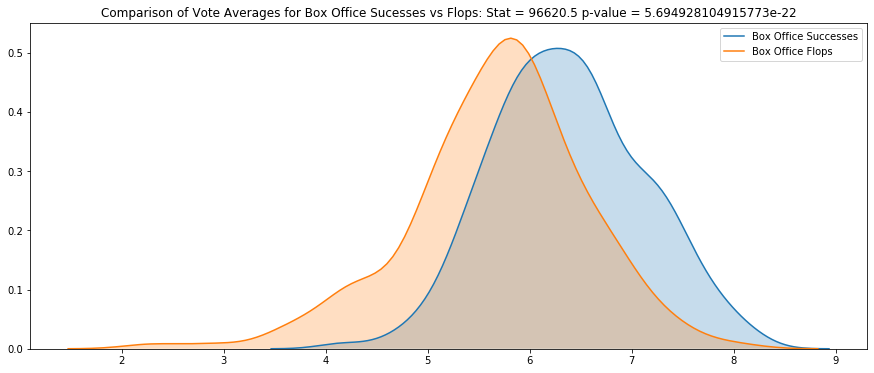

In [53]:
above50mil_success_votes = remove_outliers(movies_df[(movies_df.budget > 50000000) & (movies_df.profit > 0)].vote_average.tolist())
above50mil_flop_votes = remove_outliers(movies_df[(movies_df.budget > 50000000) & (movies_df.profit <= 0)].vote_average.tolist())

tstat, p = mannwhitneyu(above50mil_success_votes, above50mil_flop_votes, alternative='two-sided')
# tstat, p = ttest_ind(above50mil_success_votes, above50mil_flop_votes, equal_var=False)

print(f'Box office success mean={round(np.mean(above50mil_success_votes), 2)}, std={round(np.std(above50mil_success_votes), 2)}, num samples={len(above50mil_success_votes)}, shapiro-wilk={shapiro(above50mil_success_votes)}')
print(f'Box office flop mean={round(np.mean(above50mil_flop_votes), 2)}, std={round(np.std(above50mil_flop_votes), 2)}, num samples={len(above50mil_flop_votes)}, shapiro-wilk={shapiro(above50mil_flop_votes)}')

plt.figure(figsize=(15, 6))
sns.kdeplot(above50mil_success_votes, label = 'Box Office Successes', shade=True)
sns.kdeplot(above50mil_flop_votes, label = 'Box Office Flops', shade=True)
plt.title(f'Comparison of Vote Averages for Box Office Sucesses vs Flops: Stat = {round(tstat, 3)} p-value = {p}')
plt.legend()
plt.show()

Box office success mean=50.42, std=33.67, num samples=691, shapiro-wilk=(0.876802921295166, 5.95400972368973e-23)
Box office flop mean=17.77, std=10.62, num samples=188, shapiro-wilk=(0.9154714345932007, 6.354663018015572e-09)


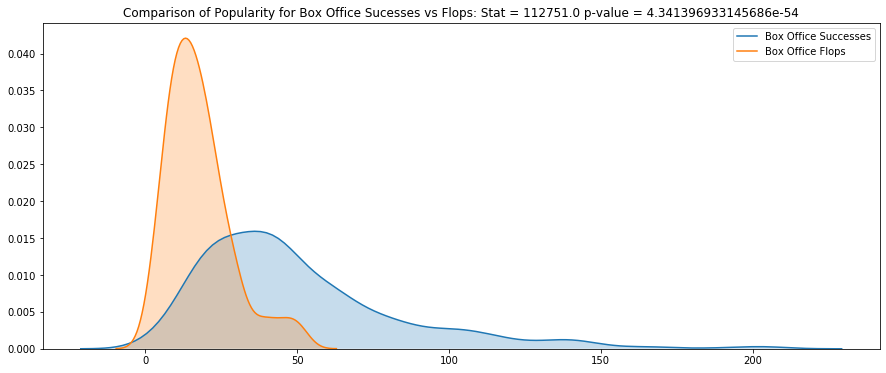

In [54]:
above50mil_success_votes = remove_outliers(movies_df[(movies_df.budget > 50000000) & (movies_df.profit > 0)].popularity.tolist())
above50mil_flop_votes = remove_outliers(movies_df[(movies_df.budget > 50000000) & (movies_df.profit <= 0)].popularity.tolist())

tstat, p = mannwhitneyu(above50mil_success_votes, above50mil_flop_votes, alternative='two-sided')
# tstat, p = ttest_ind(above50mil_success_votes, above50mil_flop_votes, equal_var=False)
print(f'Box office success mean={round(np.mean(above50mil_success_votes), 2)}, std={round(np.std(above50mil_success_votes), 2)}, num samples={len(above50mil_success_votes)}, shapiro-wilk={shapiro(above50mil_success_votes)}')
print(f'Box office flop mean={round(np.mean(above50mil_flop_votes), 2)}, std={round(np.std(above50mil_flop_votes), 2)}, num samples={len(above50mil_flop_votes)}, shapiro-wilk={shapiro(above50mil_flop_votes)}')

plt.figure(figsize=(15, 6))
sns.kdeplot(above50mil_success_votes, label = 'Box Office Successes', shade=True)
sns.kdeplot(above50mil_flop_votes, label = 'Box Office Flops', shade=True)
plt.title(f'Comparison of Popularity for Box Office Sucesses vs Flops: Stat = {round(tstat, 3)} p-value = {p}')
plt.legend()
plt.show()

In [55]:
shapiro(remove_outliers(above50mil_success_votes))

(0.9105101823806763, 1.343668180375046e-19)

In [56]:
production_df["profit"] = production_df.apply(lambda row: movies_df[movies_df.movie_id == row["movie_id"]].profit.values[0], axis=1)
production_df.profit

0        2550965087
1        2550965087
2        2550965087
3        2550965087
4         661000000
            ...    
13656       1820920
13657             0
13658             0
13659             0
13660             0
Name: profit, Length: 13661, dtype: int64

In [57]:
production_df.groupby("name", as_index=False).sum().sort_values(by="profit", ascending=False).head(10)

,name,index,id,movie_id,profit
4823,Warner Bros.,501.0,1969692.0,9859388,30582535907
4676,Universal Pictures,55.0,10263.0,12821155,28880599669
4614,Twentieth Century Fox Film Corporation,58.0,67932.0,7368901,28529983509
3358,Paramount Pictures,4.0,1140.0,8701436,27568910158
4812,Walt Disney Pictures,0.0,226.0,5093888,19105876048
978,Columbia Pictures,1.0,1005.0,8587605,17490360039
3094,New Line Cinema,8.0,1980.0,7363947,13349380804
209,Amblin Entertainment,47.0,2744.0,1420426,12587035147
1297,DreamWorks SKG,15.0,2133.0,1536650,9966033626
1313,Dune Entertainment,69.0,26196.0,2534786,9776504187


# Time series analysis and inflation adjusted

In [58]:
genres_merged.release_date = pd.to_datetime(genres_merged.release_date)

In [59]:
genres_merged.set_index("release_date", inplace=True)

In [60]:
genres_merged.head()

,budget_x,genres,homepage,movie_id,keywords,original_language,original_title,overview,popularity,production_companies,...,vote_count,director,lead_actor,profit_x,index,id,name,budget_y,profit_y,BoxOfficeSuccess
release_date,,,,,,,,,,,,,,,,,,,,,
2009-12-10,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...",...,11800,James Cameron,Sam Worthington,2550965087,0.0,28.0,Action,237000000,2550965087,1
2009-12-10,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...",...,11800,James Cameron,Sam Worthington,2550965087,1.0,12.0,Adventure,237000000,2550965087,1
2009-12-10,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...",...,11800,James Cameron,Sam Worthington,2550965087,2.0,14.0,Fantasy,237000000,2550965087,1
2009-12-10,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...",...,11800,James Cameron,Sam Worthington,2550965087,3.0,878.0,Science Fiction,237000000,2550965087,1
2007-05-19,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...",...,4500,Gore Verbinski,Johnny Depp,661000000,0.0,12.0,Adventure,300000000,661000000,1


In [61]:
timeseries_genres = genres_merged[["name", "budget_x", "revenue", "profit_x", "vote_average", "popularity"]]
timeseries_genres.resample("1M").sum()

,budget_x,revenue,profit_x,vote_average,popularity
release_date,,,,,
1916-09-30,385907,8394751,8008844,7.4,3.232447
1916-10-31,0,0,0,0.0,0.000000
1916-11-30,0,0,0,0.0,0.000000
1916-12-31,0,0,0,0.0,0.000000
1917-01-31,0,0,0,0.0,0.000000
...,...,...,...,...,...
2016-05-31,1134000000,3463912545,2329912545,75.9,672.156143
2016-06-30,2990000000,8867135872,5877135872,229.2,1620.938537
2016-07-31,1542800000,4066420763,2523620763,162.4,1234.023145


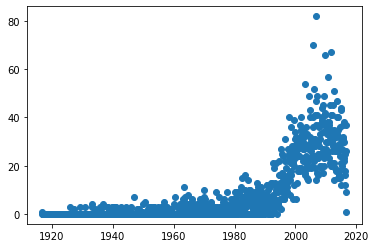

In [62]:
monthly_resample = timeseries_genres.resample("1M").count()

plt.plot_date(monthly_resample.index, monthly_resample.name)

In [63]:
# https://towardsdatascience.com/adjusting-prices-for-inflation-in-pandas-daaaa782cd89

cpi_df = pd.read_csv("CPIAUCNS.csv")
cpi_df.DATE = pd.to_datetime(cpi_df.DATE)
cpi_df.set_index("DATE", inplace=True)
cpi_df = cpi_df.resample("1Y").mean()
cpi_df["CPI_MULTIPLIER"] = cpi_df.CPIAUCNS.iloc[-1] / cpi_df.CPIAUCNS
cpi_df

,CPIAUCNS,CPI_MULTIPLIER
DATE,,
1913-12-31,9.883333,26.937909
1914-12-31,10.016667,26.579334
1915-12-31,10.108333,26.338302
1916-12-31,10.883333,24.462757
1917-12-31,12.825000,20.759168
...,...,...
2017-12-31,245.119583,1.086149
2018-12-31,251.106833,1.060251
2019-12-31,255.657417,1.041379


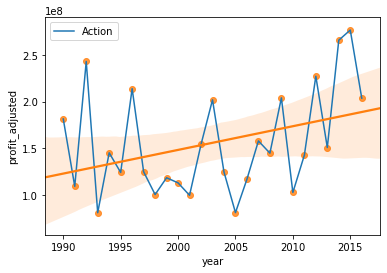

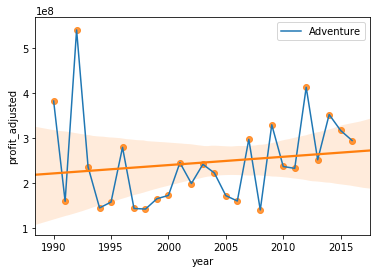

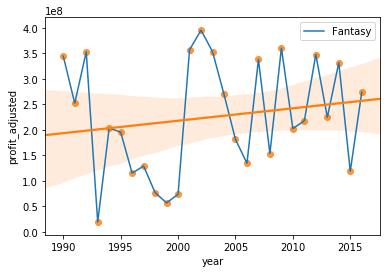

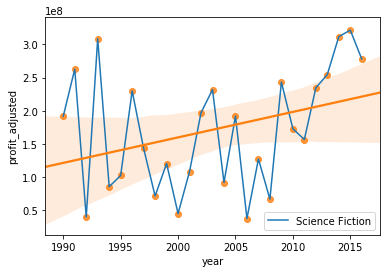

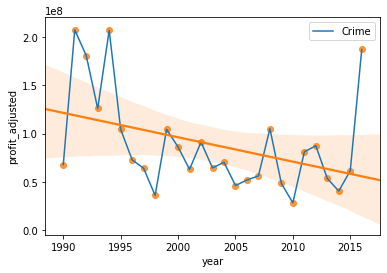

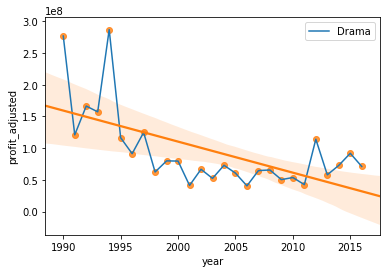

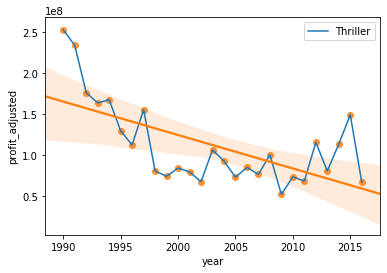

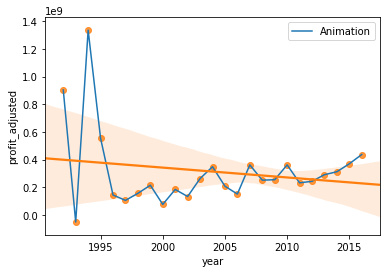

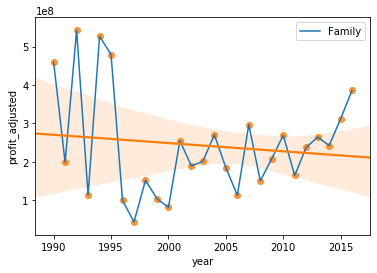

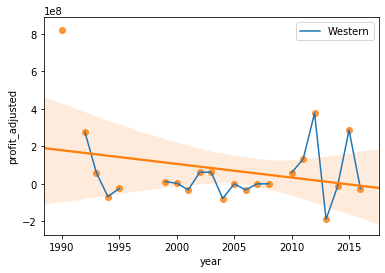

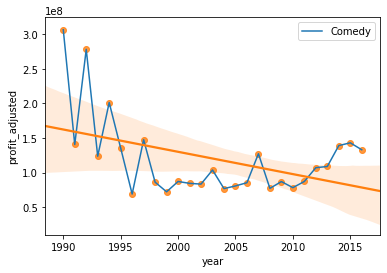

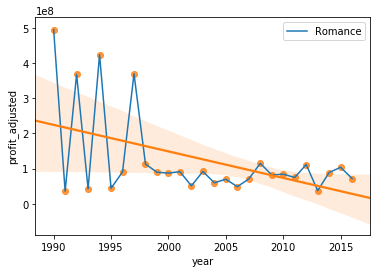

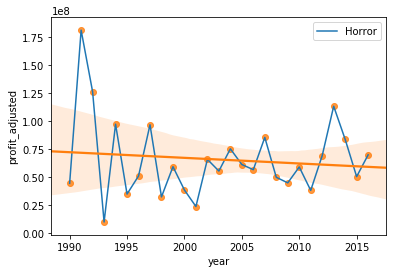

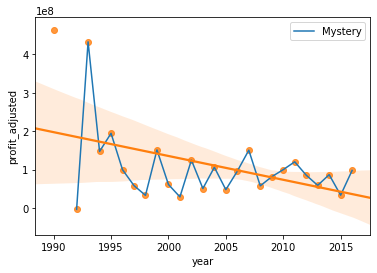

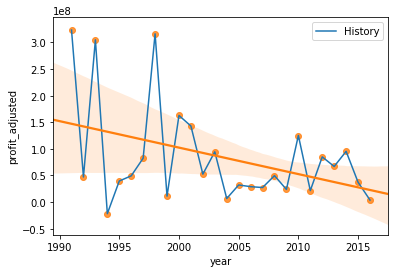

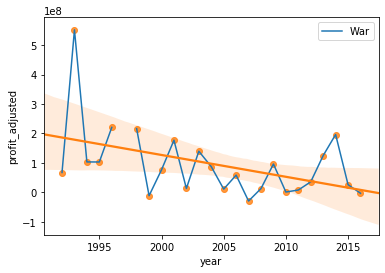

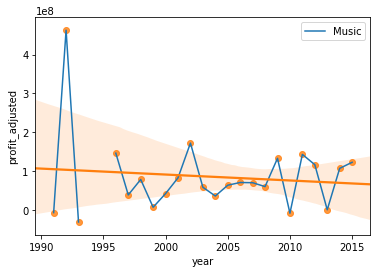

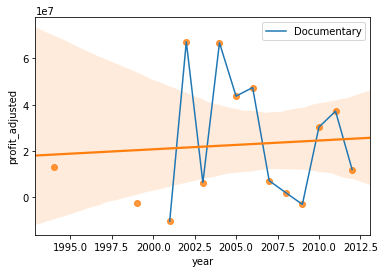

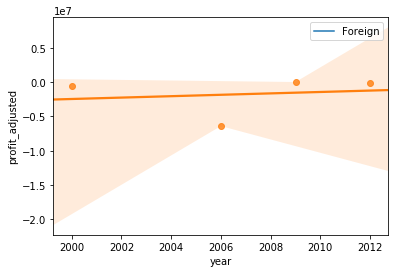

In [64]:
for genre in genres_merged.name.unique():
    yearly_resample = timeseries_genres[timeseries_genres["name"] == genre].resample("1Y").mean()
    cpi_merged = yearly_resample.merge(cpi_df, left_index=True, right_index=True, how='left')
    cpi_merged["profit_adjusted"] = cpi_merged["profit_x"] * cpi_merged.CPI_MULTIPLIER
    cpi_merged["revenue_adjusted"] = cpi_merged["revenue"] * cpi_merged.CPI_MULTIPLIER
    cpi_merged["year"] = pd.to_numeric(cpi_merged.index.year)
    cpi_merged = cpi_merged[cpi_merged.year >= 1990]
    plt.plot(cpi_merged.index.year, cpi_merged.profit_adjusted, label = genre)
    sns.regplot(cpi_merged.year, cpi_merged.profit_adjusted, data=cpi_merged)
    plt.legend()
    plt.show()

In [65]:
print(monthly_resample.index[0], monthly_resample.index[-1])
print(cpi_df.index[0], type(cpi_df.index[-1].year))

1916-09-30 00:00:00 2016-09-30 00:00:00
1913-12-31 00:00:00 <class 'int'>


In [66]:
movies_timeseries_df = movies_df.copy().set_index("release_date")
movies_timeseries_df["isFlop"] = movies_timeseries_df.apply(lambda row: (1 if row.profit <= 0 else 0), axis=1)
flop_pct_over_time = movies_timeseries_df.resample("1Y").isFlop.sum() / movies_timeseries_df.resample("1Y").isFlop.count()

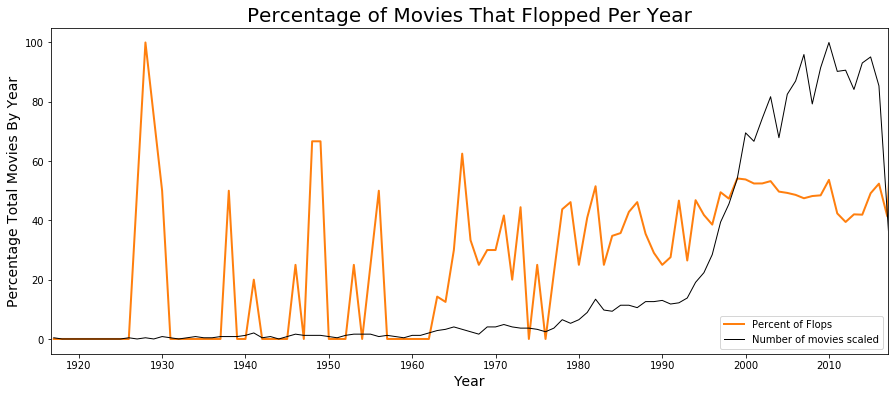

In [67]:
plt.figure(figsize=(15, 6))
plt.title("Percentage of Movies That Flopped Per Year", fontsize=20)
plt.plot(flop_pct_over_time.dropna()*100, label="Percent of Flops", linewidth=2, color='tab:orange')
plt.plot(movies_timeseries_df.resample("1Y").isFlop.count() / max(movies_timeseries_df.resample("1Y").isFlop.count()) *100, label = "Number of movies scaled", linestyle="-", color='black', linewidth=1)
plt.xlim(movies_df.release_date.min(), movies_df.release_date.max())
plt.ylabel("Percentage Total Movies By Year", fontsize=14)
plt.xlabel("Year", fontsize=14)
plt.legend()
plt.show()

# Classification modelling

## Prep

In [68]:
movies_df.release_date = pd.to_datetime(movies_df.release_date)

In [69]:
movies_df[movies_df.budget > 50000000].merge(pd.get_dummies(genres_df.set_index("movie_id").name), left_on="movie_id", right_index=True, how='inner').columns

Index(['budget', 'genres', 'homepage', 'movie_id', 'keywords',
       'original_language', 'original_title', 'overview', 'popularity',
       'production_companies', 'production_countries', 'release_date',
       'revenue', 'runtime', 'spoken_languages', 'status', 'tagline', 'title',
       'vote_average', 'vote_count', 'director', 'lead_actor', 'profit',
       'Action', 'Adventure', 'Animation', 'Comedy', 'Crime', 'Documentary',
       'Drama', 'Family', 'Fantasy', 'Foreign', 'History', 'Horror', 'Music',
       'Mystery', 'Romance', 'Science Fiction', 'TV Movie', 'Thriller', 'War',
       'Western'],
      dtype='object')

In [70]:
genres_df.columns

Index(['index', 'id', 'movie_id', 'name', 'budget', 'profit'], dtype='object')

In [71]:
bigbudget_boxoffice = movies_df[movies_df.budget > 50000000].movie_id.tolist()

reg_df = movies_df[movies_df.movie_id.isin(bigbudget_boxoffice)].merge(pd.get_dummies(genres_df[genres_df.movie_id.isin(bigbudget_boxoffice)].set_index("movie_id").name).groupby(by="movie_id").sum(), left_on="movie_id", right_index=True, how='inner')
print(reg_df.shape)
# reg_df = reg_df.merge(pd.get_dummies(keywords_df[keywords_df.movie_id.isin(bigbudget_boxoffice)].set_index("movie_id").name).groupby(by="movie_id").sum(), left_on="movie_id", right_index=True, how='inner')
# print(reg_df.shape)
reg_df["month"] = reg_df.apply(lambda row: row.release_date.month, axis=1)
reg_df["year"] = reg_df.apply(lambda row: row.release_date.year, axis=1)
reg_df = reg_df.select_dtypes(include=["int64", "float64", "uint8"])
reg_df["isFlop"] = reg_df.apply(lambda row: (1 if row.profit <= 0 else 0), axis=1)
reg_df = reg_df.drop(["movie_id", "revenue", "popularity", "profit", "vote_average", "vote_count"], axis=1)
reg_df.dropna(inplace=True)

(889, 41)


## Fit Model Function

In [72]:
def fit_model(df, algorithm):
    """
    Fit a classification model handling the minority class with the boostrap method.
    
    Arguments:
        df = DataFrame, prepared dataframe with Y = isFlop
        algorithm = initialised sklearn algorithm
        
    Returns:
        acc = float, accuracy of fitted model
        auroc = float, Area Under ROC curve of fitted model
        con_mat = 2x2 np.array, Confusion Matrix of fitted model
    
    """
    X = df.drop("isFlop", axis=1)
    Y = df.isFlop

    # Split into train and test. Use random seed to ensure models can be reproduced.
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, shuffle=True, stratify=Y, random_state=42)

    train_set = pd.concat([x_train, y_train], axis=1)
    
    # Split into minority and majority classes. In this case we know Box Office Flops are the minority 
    majority_class = train_set[train_set.isFlop == 0]
    minority_class = train_set[train_set.isFlop == 1]
    
    # Use bootstrap method to upsample minority class 
    minority_class = resample(minority_class, replace=True, n_samples=majority_class.shape[0], random_state=42)

    train_set = pd.concat([majority_class, minority_class])
    
    # Only upsample training set to ensure test set has the true ratio
    x_train = train_set.drop("isFlop", axis=1).values
    y_train = train_set.isFlop.values

    model = algorithm.fit(x_train, y_train)

    y_pred = model.predict(x_test)

#     print(f"Accuracy Score {accuracy_score(y_test, y_pred)}")
#     print(f"AUROC Score: {roc_auc_score(y_test, y_pred)}")
    return accuracy_score(y_test, y_pred), roc_auc_score(y_test, y_pred), confusion_matrix(y_test, y_pred)

In [73]:
accs = []
aurocs = []
con_mats = []

for algorithm in [LogisticRegression(), RandomForestClassifier(), GradientBoostingClassifier()]:
    acc, auroc, con_mat = fit_model(reg_df, algorithm)
    accs.append(round(acc, 3))
    aurocs.append(round(auroc, 3))
    con_mats.append(con_mat)
    print(f"Algorithm: {algorithm} \nAccuracy: {acc} \nAUROC: {auroc} \nConfusion Matrix: \n{con_mat}")

Algorithm: LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False) 
Accuracy: 0.7865168539325843 
AUROC: 0.5 
Confusion Matrix: 
[[140   0]
 [ 38   0]]
Algorithm: RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False) 
Accuracy: 0.7528089

In [74]:
model_stats_df = pd.DataFrame({"Accuracy":accs, "AUROC":aurocs})
model_stats_df = model_stats_df.T
model_stats_df.columns = ["Logistic Regression", "Random Forest", "Gradient Boosting"]
model_stats_df

,Logistic Regression,Random Forest,Gradient Boosting
Accuracy,0.787,0.753,0.680
AUROC,0.500,0.527,0.576


In [75]:
np.vstack((accs, aurocs))

array([[0.787, 0.753, 0.68 ],
       [0.5  , 0.527, 0.576]])

In [76]:
s = model_stats_df.style.format('{:.3f}')
cell_hover = {  # for row hover use <tr> instead of <td>
    'selector': 'td:hover',
    'props': [('background-color', '#ffffb3')]
}
index_names = {
    'selector': '.index_name',
    'props': 'font-style: italic; color: darkgrey; font-weight:normal;'
}
headers = {
    'selector': '.column_name',
    'props': 'background-color: #000066; color: white;'
}
s = s.set_table_styles([{'selector': 'th', 'props': [('background-color', '#000066'), ('color', 'white')]}])
#s = s.set_table_styles([{'selector': 'th.col_heading', 'props': ('text-align' 'center')}])
s

,Logistic Regression,Random Forest,Gradient Boosting
Accuracy,0.787,0.753,0.680
AUROC,0.500,0.527,0.576


In [77]:
formatted_confusion_matrices_df = pd.DataFrame(np.hstack(con_mats),
                                            index=pd.Index(
                                                ['Success (Negative)', 'Flop (Positive)'], name='Actual Label:'),
                                            columns=pd.MultiIndex.from_product([['Logistic Regression', 'Random Forest', 'Gradient Boosting'], ['Success', 'Flop']], names=['Model:', 'Predicted:']))


cell_hover = dict(  # for row hover use <tr> instead of <td>
    selector = "td:hover",
    props = [('background-color', '#ffffb3'),]
)
index_names = dict(
    selector = ".index_name",
    props = [('font-style', 'italic'), ('color', 'darkgrey'), ('font-weight', 'normal')]
)
headers = {
    'selector': '.column_name',
    'props': 'background-color: #000066; color: white;'
}

formatted_confusion_matrices_df.style.set_table_styles(cell_hover)

# f